In [248]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model as lm
import matplotlib.pyplot as plt

# Data sampling and collection

In [255]:
biocon = pd.read_csv('datasets/bioCON_plant_diversity.txt', delimiter='\t')
#species = pd.read_csv('datasets/species.txt', delimiter='\t')

### BIOCON
The BIOCON dataset comes from an ecological experiment at the University of Minnesota's Cedar Creek Ecosystem Science Reserve.
Starting in 1997, the goal of this experiment was to explore how different plant communities responded to three environmental changes across the globe. The environmental changes were quantified into increasing nitrogen deposition, increasing atmospheric CO2, and decreasing biodiversity. These three aspects were chosen based on their importance to plant growth and development as CO2 is part of photosynthesis; nitrogen is a key nutritiant for plant growth; and data shows that there is a decreasing trend in biodiversity.

While a lot of research already have been done on these topics, several questions remain unanswered. The BIOCON experiment aims to address how these issues affect each other, and which consequences might arise when systems are exposed to these at the same time.

The collection of the data 
The data quality was preserved and ensured by [Data quality process from experiment]

A complementary dataset containing information on which plant species were planted in the different plots was also used in the analysis. This data already contained one-hot encoded values, which made it easier to perform our analysis as we did not have to perform any manipulation on it.

### Bias
Was there any potential bias introduced in the sampling process?
* Bias-variance tradeoff
* Tell something about the random sampling done in the splitting of the data into training and validation set.
* Should we show some measurement of the bias?
* error and noise was removed in data quality process?
* As our model is not similar to the underlying function which described the behavior of the dataset, there will be some model risk. Try to calculate this? (Lecture 18 - Probability II)

# Data cleaning

What type of data are you currently exploring?
Frequency, 

What is the granularity of the data?

What does the distribution of the data look like? Are there any outliers? Are there any missing or invalid entries?

The BIOCON dataset consists of
Encoding

In [185]:
biocon.head()

,Year,Plot,Ring,CO2 Treatment,Nitrogen Treatment,CountOfSpecies,CountOfGroup,Experiment,monospecies,Monogroup,Water Treatment,Temp Treatment,Depth,Carbon(%),Nitrogen(%),C/N Ratio
0,2002,1,1,Cenrich,Namb,4,2,M,,,,,0-10,0.618,0.074,8.351351351
1,2002,1,1,Cenrich,Namb,4,2,M,,,,,10-20,0.515,0.057,9.035087719
2,2002,1,1,Cenrich,Namb,4,2,M,,,,,20-40,0.142,0.023,6.173913043
3,2002,1,1,Cenrich,Namb,4,2,M,,,,,40-60,0.132,0.016,8.25
4,2002,2,1,Cenrich,Namb,1,1,M,Bouteloua gracilis,C-4,,,0-10,0.55,0.07,7.857142857


In [186]:
biocon.dtypes

Year                   int64
Plot                   int64
Ring                  object
CO2 Treatment         object
Nitrogen Treatment    object
CountOfSpecies         int64
CountOfGroup           int64
Experiment            object
monospecies           object
Monogroup             object
Water Treatment       object
Temp Treatment        object
Depth                 object
Carbon(%)             object
Nitrogen(%)           object
C/N Ratio             object
dtype: object

In [187]:
biocon['monospecies'].unique()

array([' ', 'Bouteloua gracilis', 'Asclepias tuberosa',
       'Schizachyrium scoparium', 'Amorpha canescens', 'Bromus inermis',
       'Agropyron repens', 'Lespedeza capitata', 'Petalostemum villosum',
       'Poa pratensis', 'Solidago rigida', 'Anemone cylindrica',
       'Koeleria cristata', 'Achillea millefolium', 'Lupinus perennis',
       'Andropogon gerardi', 'Sorghastrum nutans'], dtype=object)

The unvalid values are replaced to a standardized value so we easily can manipulate them at the same. The numerical values are parsed to fulfill the requirements from regression analysis.

In [256]:
biocon['Carbon(%)'].replace('', np.nan, inplace=True)
biocon['Nitrogen(%)'].replace('', np.nan, inplace=True)
biocon['C/N Ratio'].replace(' ', np.nan, inplace=True)
biocon.dropna(subset=['Carbon(%)', 'Nitrogen(%)', 'C/N Ratio'], inplace=True)
biocon['Carbon(%)'] = biocon['Carbon(%)'].astype(float)
biocon['Nitrogen(%)'] = biocon['Nitrogen(%)'].astype(float)
biocon['C/N Ratio'] = biocon['C/N Ratio'].astype(float)

### Remove outliers
From the visualization below, we can see that the different depths have different outliers.
We took this into consideration when deciding the thresholds of which the values were marked as outliers.

In [251]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[(data[variable] >= lower) & (data[variable] <= upper)]

#### Outliers in the carbon values

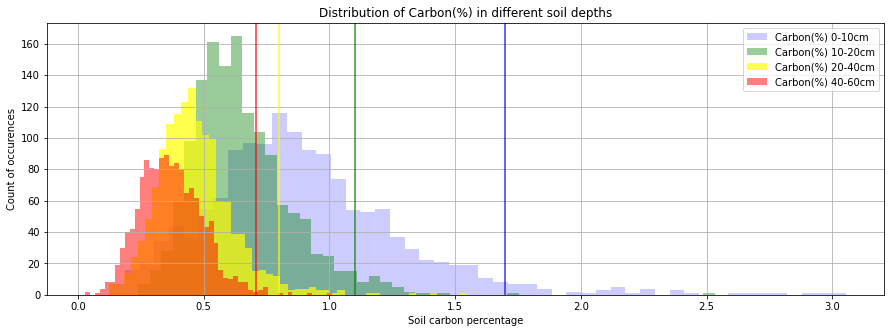

In [270]:
biocon[biocon['Depth'] == '0-10']['Carbon(%)'].hist(bins=50, figsize=(15,5), alpha=0.2, color='blue')
biocon[biocon['Depth'] == '10-20']['Carbon(%)'].hist(bins=50, figsize=(15,5), alpha=0.4, color='green')
biocon[biocon['Depth'] == '20-40']['Carbon(%)'].hist(bins=50, figsize=(15,5), alpha=0.7, color='yellow')
biocon[biocon['Depth'] == '40-60']['Carbon(%)'].hist(bins=50, figsize=(15,5), alpha=0.5, color='red')
plt.xlabel('Soil carbon percentage')
plt.ylabel('Count of occurences')
plt.title('Distribution of Carbon(%) in different soil depths')
plt.legend(['Carbon(%) 0-10cm','Carbon(%) 10-20cm','Carbon(%) 20-40cm','Carbon(%) 40-60cm'])

# The threshold values calculated in the cell below
plt.axvline(1.7, color='blue', alpha=0.8)
plt.axvline(1.1, color='green', alpha=0.8)
plt.axvline(0.8, color='yellow', alpha=0.8)
plt.axvline(0.71, color='red', alpha=0.8)

In [294]:
# Observations more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are marked as outliers.
for depth in ['0-10','10-20','20-40','40-60']:
    df = biocon[biocon['Depth'] == depth]
    column = 'Carbon(%)'
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    low = (Q1 - 1.5 * IQR)
    high = (Q3 + 1.5 * IQR)
    
    print(depth)
    print('Low:', low)
    print('High:', high)
    #filtered_index = df[((df[column] <= low) or (df[column] >= high))].index
    #biocon.drop(biocon[df[column] >= high].index, inplace=True)
    # Remove Outliers

0-10
Low: 1.0566499999999994
High: 3.0786500000000006


/var/folders/jr/90trlx1148g4hs4p4rs_y01m0000gn/T/ipykernel_49002/2338601788.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  biocon.drop(biocon[df[column] >= high].index, inplace=True)


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

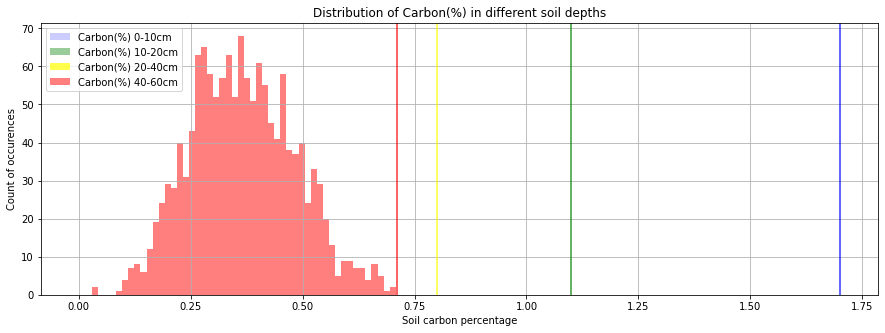

In [293]:
marius[marius['Depth'] == '0-10']['Carbon(%)'].hist(bins=50, figsize=(15,5), alpha=0.2, color='blue')
marius[marius['Depth'] == '10-20']['Carbon(%)'].hist(bins=50, figsize=(15,5), alpha=0.4, color='green')
marius[marius['Depth'] == '20-40']['Carbon(%)'].hist(bins=50, figsize=(15,5), alpha=0.7, color='yellow')
marius[marius['Depth'] == '40-60']['Carbon(%)'].hist(bins=50, figsize=(15,5), alpha=0.5, color='red')
plt.xlabel('Soil carbon percentage')
plt.ylabel('Count of occurences')
plt.title('Distribution of Carbon(%) in different soil depths')
plt.legend(['Carbon(%) 0-10cm','Carbon(%) 10-20cm','Carbon(%) 20-40cm','Carbon(%) 40-60cm'])

# The threshold values calculated in the cell below
plt.axvline(1.7, color='blue', alpha=0.8)
plt.axvline(1.1, color='green', alpha=0.8)
plt.axvline(0.8, color='yellow', alpha=0.8)
plt.axvline(0.71, color='red', alpha=0.8)

#### Outliers in the nitrogen values

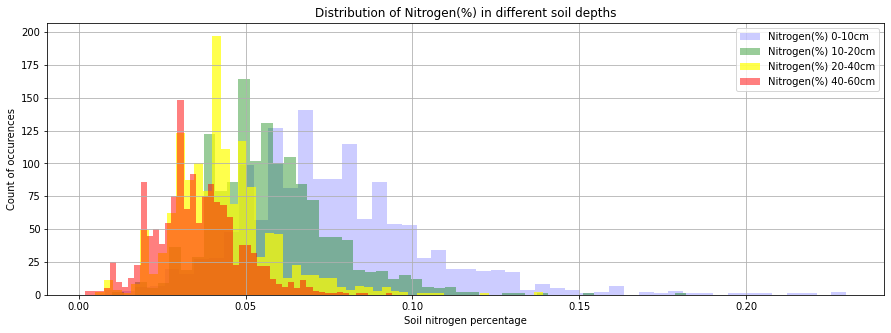

In [191]:
biocon[biocon['Depth'] == '0-10']['Nitrogen(%)'].hist(bins=50, figsize=(15,5), alpha=0.2, color='blue')
biocon[biocon['Depth'] == '10-20']['Nitrogen(%)'].hist(bins=50, figsize=(15,5), alpha=0.4, color='green')
biocon[biocon['Depth'] == '20-40']['Nitrogen(%)'].hist(bins=50, figsize=(15,5), alpha=0.7, color='yellow')
biocon[biocon['Depth'] == '40-60']['Nitrogen(%)'].hist(bins=50, figsize=(15,5), alpha=0.5, color='red')
plt.xlabel('Soil nitrogen percentage')
plt.ylabel('Count of occurences')
plt.title('Distribution of Nitrogen(%) in different soil depths')
plt.legend(['Nitrogen(%) 0-10cm','Nitrogen(%) 10-20cm','Nitrogen(%) 20-40cm','Nitrogen(%) 40-60cm'])

From the distribution, we can see that certain values dominate the distribution creating remarkable gaps. This is probably due to some measurements being rounded to the same values in the experiment. Therefore, this is not something that we will be further concerned about in our analysis. Below we can see the top 5 nitrogen percentage values.

In [192]:
biocon[biocon['Depth'] == '40-60']['Nitrogen(%)'].value_counts().head()

0.030    107
0.020     68
0.040     56
0.034     45
0.035     38
Name: Nitrogen(%), dtype: int64

In [ ]:
for depth in ['0-10','10-20','20-40','40-60']:
    df = biocon[biocon['Depth'] == depth]
    column = 'Nitrogen(%)'
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    low = (Q1 - 1.5 * IQR)
    high = (Q3 + 1.5 * IQR)
    
    print(depth)
    print('Low:', low)
    print('High:', high)
    biocon = remove_outliers(df, column, low, high)

# Exploratory data analysis

A sample is a subset of the population.
* Samples are often used to make inferences about the population.
        - Inference: quantifying degree of certainity in our models of the world.
        Will the patterns that we found in our data also appear in new observations?
How accurate are our predictions?!

To answer this, we will use different tools and methods to see if we can find some inference in the data we collected.
With Exploration, we will use visualizations and descriptive statistics to make some predictions on the data by using machine learning and fitting a regression model, optimization it to the data we have collected based on our thoughts and ideas obtained from earlier exploration.

### The count of plant species has effect on the Carbon levels in the soil
Before diving into the analysis, the group did some research on the topics of how the climate change has an impact on the biodiversity. One of the research papers we read, mentioned that the count of plant species had an impact on the soil levels of Nitrogen and Carbon. This quote made us interested and inspired us to form the hypothesis **"The count of plant species has effect on the Carbon levels in the soil"** which we would try to answer in our own exploratory data analysis.

* Any other interesting correlation we wanted to look at? Add them below or reference to other notebooks

Text(0.5, 1.0, 'The average Carbon level for each count of species')

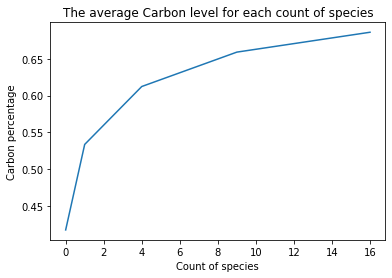

In [193]:
biocon.groupby(['CountOfSpecies'])['Carbon(%)'].mean().plot()
plt.ylabel('Carbon percentage')
plt.xlabel('Count of species')
plt.title('The average Carbon level for each count of species')

Text(0.5, 1.0, 'The average Nitrogen level for each count of species')

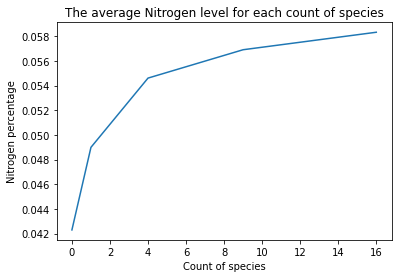

In [194]:
biocon.groupby(['CountOfSpecies'])['Nitrogen(%)'].mean().plot()
plt.ylabel('Nitrogen percentage')
plt.xlabel('Count of species')
plt.title('The average Nitrogen level for each count of species')

In [195]:
biocon[(biocon['Temp Treatment'] == 'HTelv') | (biocon['Temp Treatment'] == 'HTamb')]['Carbon(%)'].mean()

0.6662741514360313

### Nitrogen percentage based on count of species and depth


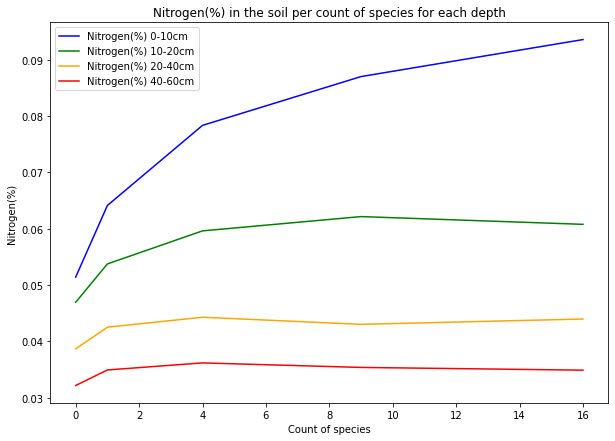

In [196]:
df = bicon.loc[:, ['CountOfSpecies', 'Depth', 'Nitrogen(%)', 'Nitrogen Treatment']].copy()

df['Nitrogen(%)'] = pd.to_numeric(df['Nitrogen(%)'], errors='coerce')
df['CountOfSpecies'] = pd.to_numeric(df['CountOfSpecies'], errors='coerce')

#fig, axes = plt.subplots(nrows=2, ncols=2)

ax = df[(df['Depth'] == '0-10')].groupby('CountOfSpecies').mean().plot(color='blue', figsize=(10,7))
df[(df['Depth'] == '10-20')].groupby('CountOfSpecies').mean().plot(ax=ax, color='green')
df[(df['Depth'] == '20-40')].groupby('CountOfSpecies').mean().plot(ax=ax, color='orange')
df[(df['Depth'] == '40-60')].groupby('CountOfSpecies').mean().plot(ax=ax, color='red')

plt.xlabel('Count of species')
plt.ylabel('Nitrogen(%)')
plt.title('Nitrogen(%) in the soil per count of species for each depth')
plt.legend(['Nitrogen(%) 0-10cm','Nitrogen(%) 10-20cm','Nitrogen(%) 20-40cm','Nitrogen(%) 40-60cm'])

Text(0.5, 1.0, 'Carbon levels')

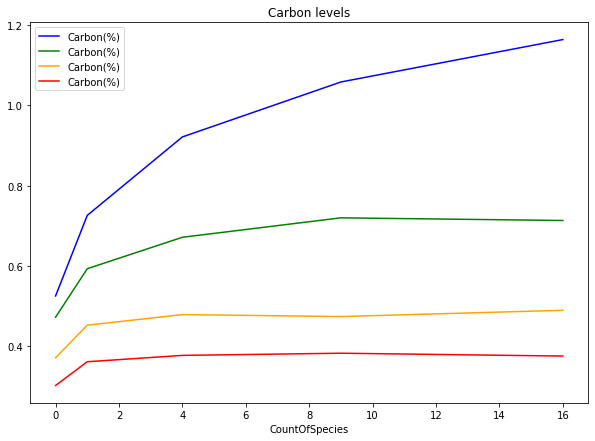

In [197]:
df = bicon.loc[:, ['CountOfSpecies', 'Depth', 'Carbon(%)']].copy()

df['Carbon(%)'] = pd.to_numeric(df['Carbon(%)'], errors='coerce')
df['CountOfSpecies'] = pd.to_numeric(df['CountOfSpecies'], errors='coerce')

#fig, axes = plt.subplots(nrows=2, ncols=2)

ax = df[(df['Depth'] == '0-10')].groupby('CountOfSpecies').mean().plot(color='blue', figsize=(10,7))
df[(df['Depth'] == '10-20')].groupby('CountOfSpecies').mean().plot(ax=ax, color='green')
df[(df['Depth'] == '20-40')].groupby('CountOfSpecies').mean().plot(ax=ax, color='orange')
df[(df['Depth'] == '40-60')].groupby('CountOfSpecies').mean().plot(ax=ax, color='red')
plt.title('Carbon levels')

From the plot above, we can see that the deeper values have lower values of nitrogen.

We can also see that the slope is similar in the different depths, but the scaling is different

In [198]:
biocon.groupby('Year').mean()

,Plot,CountOfSpecies,CountOfGroup,Carbon(%),Nitrogen(%),C/N Ratio
Year,,,,,,
2002,186.111336,5.192308,2.269231,0.555184,0.056675,9.873872
2007,186.000000,5.196765,2.269542,0.644554,0.056111,11.191059
2012,185.896831,5.199595,2.270398,0.619814,0.054675,11.216634
2016,183.597956,5.695060,2.469336,0.559779,0.043070,13.676147


### The impact of nitrogen and CO2 treatment
The plots that received nitrogen treatment, was treated with 34% ammonium nitrate pellets three times per growing season and also 15N enrichement at the time of fertilization three times per growing season. Three of the six rings got CO2 enriched air with a CO2 concentration of 560 ppm, while the ambient level was 368 ppm. This treatment was done using Free Air CO2 Encrichement (FACE) technology.

We wanted to see how these treatments impacted the soil levels of nitrogen and carbon.

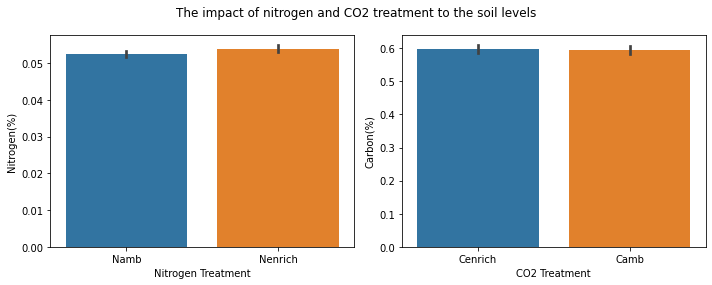

In [199]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
#biocon.loc[:,['Nitrogen Treatment', 'Nitrogen(%)']].plot(..., ax=ax1)
sns.barplot(data = biocon, x="Nitrogen Treatment", y='Nitrogen(%)', ax=ax1)
sns.barplot(data = biocon, x="CO2 Treatment", y='Carbon(%)', ax=ax2)
plt.suptitle('The impact of nitrogen and CO2 treatment to the soil levels')
plt.tight_layout()

In the figures above, we can se a slight but not significant change in the soil levels of nitrogen and carbon after receiving treatments increasing these values.

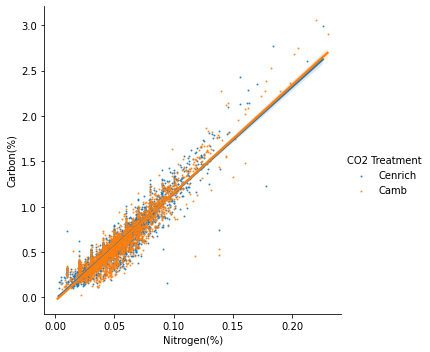

In [200]:
sns.lmplot(x = "Nitrogen(%)", y = "Carbon(%)", data = biocon, hue = "CO2 Treatment", scatter_kws={"s": 1})

In [201]:
biocon.groupby(['Ring'])['Carbon(%)', 'Nitrogen(%)', 'CountOfSpecies'].mean()

/var/folders/jr/90trlx1148g4hs4p4rs_y01m0000gn/T/ipykernel_49002/4173151406.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  biocon.groupby(['Ring'])['Carbon(%)', 'Nitrogen(%)', 'CountOfSpecies'].mean()


,Carbon(%),Nitrogen(%),CountOfSpecies
Ring,,,
,0.590000,0.040000,1.000000
1,0.497032,0.045250,5.328649
2,0.496112,0.044348,5.321238
3,0.673258,0.059639,5.254777
4,0.594512,0.053232,5.327641
5,0.622654,0.054147,5.329018
6,0.693917,0.062060,5.247379


**Temperature Treatment**

In the BioCON research experiment, 48 of the plots in the study recieved a temperature treatment of 2 deegrees C meant to represent the minimum warming predicted the next century for Central North America. Therefore, we wanted to check if this treatment had any correlation with the amount of Carbon and Nitrogen in the soil for each plot. All of the 48 plots which recieved the treatment all had the diversity of 9 different species. In order to see if the treatment had any significant effect, we compared the overall mean for the plots affected by temperature treatment with the plot not affected, and found little reason to belive this has a impact.

In [202]:
biocon[biocon['CountOfSpecies'] == 9].groupby('Temp Treatment')['Carbon(%)', 'Nitrogen(%)'].mean()

/var/folders/jr/90trlx1148g4hs4p4rs_y01m0000gn/T/ipykernel_49002/2545590124.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  biocon[biocon['CountOfSpecies'] == 9].groupby('Temp Treatment')['Carbon(%)', 'Nitrogen(%)'].mean()


,Carbon(%),Nitrogen(%)
Temp Treatment,,
,0.654009,0.058860
HTamb,0.664361,0.054079
HTelv,0.668177,0.053880


In [203]:
biocon.groupby('Year')['Carbon(%)', 'Nitrogen(%)'].mean()

/var/folders/jr/90trlx1148g4hs4p4rs_y01m0000gn/T/ipykernel_49002/2658047545.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  biocon.groupby('Year')['Carbon(%)', 'Nitrogen(%)'].mean()


,Carbon(%),Nitrogen(%)
Year,,
2002,0.555184,0.056675
2007,0.644554,0.056111
2012,0.619814,0.054675
2016,0.559779,0.043070


### Feature Engineering
After confirming our hypothesis, we got confident that the count of species had an impact on the soil levels of Carbon and Nitrogen.
For our machine learning regression model, we now wanted to find other attributes of the plots that would increase the accurecy of predicting the soil levels of nitrogen and carbon.

* **Write why we chose the different features here**
##### Count of species
As proved in our hypothesis above, this was an obvious choice to include in the fitting of our model.
##### Depth
As the soil levels decrease at greater depths in the soil, this was valuable to include as a feature.
The values were encoded as labels depending on which range the samples was collected from, we needed to replace the values. We chose to use **TODO: The average depth (To make it continious)? integer encoding (0,1,2,3,4)?**
##### Species
This information was not a part of 
Plot shows that the different species gives different carbon/nitrogen levels (monospecies column), therefore it makes sense to use species as a feature
We saw that the monospecies column only contained values for a few rows, therefore we joined the dataset with another dataset from the same experiment containing which plant species was present in the different plots.
One-hot encoded - It was easily available, and there is no ordinal relationship which is why an integer encoding would not be sufficient.

##### Features not included

Features like index, plot, etc. does not have an impact of the soil levels and are only present as labeling. Therefore, these were removed from the dataset before the fitting of the model.

Plots show that there is no big difference between the different treatments and the carbon/nitrogen percent in the soil **Paste the proof Kristofer made of the treatments not having significant impact**

Temperature treatment

We did not use "Year" as a feature because we would presumably want to use this model to predict values with data in later years, which would then contain "Year" values not used in the fitting of the model.

In [207]:
total = pd.merge(biocon, species, on='Plot')
total = total.drop(columns = ['Ring_x','CO2 Treatment', 'Nitrogen Treatment', 'Experiment', 'monospecies',
                              'Monogroup', 'Water Treatment', 'Temp Treatment', 'CountOfGroup', 'Ring_y', 'C/N Ratio', 'Year'])
total['Depth'].replace(['0-10','10-20','20-40', '40-60'], [0,1,2,3], inplace=True)
total

,Plot,CountOfSpecies,Depth,Carbon(%),Nitrogen(%),Achillea millefolium,Agropyron repens,Amorpha canescens,Andropogon gerardi,Anemone cylindrica,...,Bouteloua gracilis,Bromus inermis,Koeleria cristata,Lespedeza capitata,Lupinus perennis,Petalostemum villosum,Poa pratensis,Schizachyrium scoparium,Solidago rigida,Sorghastrum nutans
0,1,4,0,0.618,0.074,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,1,4,1,0.515,0.057,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,1,4,2,0.142,0.023,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,1,4,3,0.132,0.016,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,1,4,0,1.000,0.077,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5618,371,0,3,0.262,0.028,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5619,371,0,1,0.490,0.047,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5620,371,0,0,0.809,0.066,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5621,371,0,2,0.405,0.037,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [205]:
total.dtypes

Plot                         int64
CountOfSpecies               int64
Carbon(%)                  float64
Nitrogen(%)                float64
Achillea millefolium         int64
Agropyron repens             int64
Amorpha canescens            int64
Andropogon gerardi           int64
Anemone cylindrica           int64
Asclepias tuberosa           int64
Bouteloua gracilis           int64
Bromus inermis               int64
Koeleria cristata            int64
Lespedeza capitata           int64
Lupinus perennis             int64
Petalostemum villosum        int64
Poa pratensis                int64
Schizachyrium scoparium      int64
Solidago rigida              int64
Sorghastrum nutans           int64
dtype: object

# Data modeling and inferences

Here are a few components your notebook must address if your focus is on modeling:
* What type of machine learning problem are you investigating? 
* What model do you plan on using and why? 
* Does your model require hyperparameter tuning? If so, how do you approach it? 
* How do you engineer the features for your model? What are the rationales behind selecting these features? 
* How do you perform cross validation on your model? 
* What loss metrics are you using to evaluate your model? 
* From a bias-variance tradeoff standpoint, how do you assess the performance of your model? 
* How do you check if it is overfitting? 
* How would you improve your model based on the outcome?

If you are choosing to pursue your research question from an inference angle
* Your notebook must demonstrate sufficient analysis and visualization to support your conclusion.
* You must have a clearly constructed hypothesis test (including a clearly defined test statistic, significance level, and justification of chosen procedure)
* We will not restrict you to the type of statistical test you conduct as there are many different statistical techniques that may apply to your case. However, we also ask that you provide detailed justification for the techniques you choose and how it allows you make those inferences.

In [59]:
biocon.head()

,Year,Plot,Ring,CO2 Treatment,Nitrogen Treatment,CountOfSpecies,CountOfGroup,Experiment,monospecies,Monogroup,Water Treatment,Temp Treatment,Depth,Carbon(%),Nitrogen(%),C/N Ratio
0,2002,1,1,Cenrich,Namb,4,2,M,,,,,0-10,0.618,0.074,8.351351351
1,2002,1,1,Cenrich,Namb,4,2,M,,,,,10-20,0.515,0.057,9.035087719
2,2002,1,1,Cenrich,Namb,4,2,M,,,,,20-40,0.142,0.023,6.173913043
3,2002,1,1,Cenrich,Namb,4,2,M,,,,,40-60,0.132,0.016,8.25
4,2002,2,1,Cenrich,Namb,1,1,M,Bouteloua gracilis,C-4,,,0-10,0.55,0.07,7.857142857


Write something more about the training process etc.

### Cross validation
We separated the dataset into a training set and validation/ test set. The split was done in 80% training and the rest as the validation.


In [208]:
np.random.seed(1337)

def train_test_split(data):
    lenght = data.shape[0]
    shuffled_indices = np.random.permutation(lenght)
    
    train_indices = np.array(shuffled_indices[:int(lenght*0.8)])
    test_indices = np.array(shuffled_indices[int(lenght*0.8):])
    train = data.iloc[train_indices]
    test = data.iloc[test_indices]
    return train, test
    
train, test = train_test_split(total)

Xtrain = train.drop(columns=['Carbon(%)']).to_numpy()
ytrain = train.loc[:, 'Carbon(%)'].to_numpy()

Xtest = test.drop(columns=['Carbon(%)']).to_numpy()
ytest = test.loc[:, 'Carbon(%)'].to_numpy()


linear_model = lm.LinearRegression(fit_intercept=True)
type(ytrain[0])

numpy.float64

In [209]:
# Fit the 1st model
# Compute the fitted and predicted values of Log Sale Price for 1st model
linear_model.fit(Xtrain, ytrain)
y_fitted = linear_model.predict(Xtrain)
y_predicted = linear_model.predict(Xtest)

### Measuring error
To evaluate our model, we used the rmse (Root Mean Squared Error) performance metric.
* **Why did we choose this?**

In [210]:
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

In [211]:
# Training and test errors for the 1st model
training_error_m1 = rmse(y_fitted, ytrain)
test_error_m1 = rmse(y_predicted, ytest)

print("1st Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1, test_error_m1))

1st Model
Training RMSE: 0.10568108265877936
Test RMSE: 0.09439772043663804



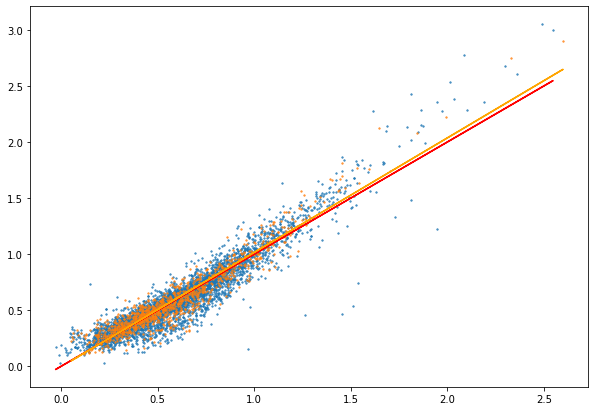

In [242]:
x1, y1 = y_fitted, ytrain
x2, y2 = y_predicted, ytest

plt.figure(figsize=(10,7))
plt.scatter(x1, y1, alpha=0.8, linewidth=0.5, s=3)
plt.scatter(x2, y2, alpha=0.8, linewidth=0.5, s=3)

m1, b1 = np.polyfit(x1, y1, 1)
m2, b2 = np.polyfit(x2, y2, 1)

#add linear regression line to scatterplot 
plt.plot(x1, m1*x1+b1, color='red')
plt.plot(x2, m2*x2+b2, color='orange')

### Bias-variance tradeoff
What do we think of our result?

https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error

This result says that we are ‘better’ at predicting the unknown values than the learned values, which does not make sense in the machine learning essence of predicting the unknown. This is a flag indicating that the data splitting method might need to be re-evaluated. 

This also indicates that there is a sampling bias in our test set, as the test cases was easily predicted by the model and is probably similar values to those it has been trained on.

Both of the values are very low, and are quite similar, this means that the model has a good fit as it can replicate the validation data.

If your test error is less than the training error, this means that there is a sampling bias in your test. (link)

In [22]:
train

,Plot,CountOfSpecies,Carbon(%),Nitrogen(%),Achillea millefolium,Agropyron repens,Amorpha canescens,Andropogon gerardi,Anemone cylindrica,Asclepias tuberosa,Bouteloua gracilis,Bromus inermis,Koeleria cristata,Lespedeza capitata,Lupinus perennis,Petalostemum villosum,Poa pratensis,Schizachyrium scoparium,Solidago rigida,Sorghastrum nutans
3372,223,1,0.5713,0.0532,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
610,41,4,0.5450,0.0520,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0
5385,355,16,0.7124,0.0665,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2011,133,9,0.6530,0.0520,1,0,0,0,0,0,1,1,1,0,0,1,1,1,1,1
2258,149,9,0.6030,0.0660,0,1,1,1,0,0,0,0,1,1,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,236,16,0.9549,0.0784,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3582,236,16,1.2620,0.1010,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1279,85,4,0.5230,0.0450,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
1735,115,1,0.6650,0.0510,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [23]:
test

,Plot,CountOfSpecies,Carbon(%),Nitrogen(%),Achillea millefolium,Agropyron repens,Amorpha canescens,Andropogon gerardi,Anemone cylindrica,Asclepias tuberosa,Bouteloua gracilis,Bromus inermis,Koeleria cristata,Lespedeza capitata,Lupinus perennis,Petalostemum villosum,Poa pratensis,Schizachyrium scoparium,Solidago rigida,Sorghastrum nutans
81,6,4,0.583,0.043,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1
4566,301,16,1.288,0.094,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3959,261,1,0.506,0.068,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2063,136,4,0.565,0.047,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
3432,227,1,0.512,0.060,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239,213,16,0.870,0.060,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1256,84,9,0.536,0.053,0,0,1,1,0,1,1,0,0,1,1,1,1,1,0,0
860,57,1,0.475,0.042,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
189,13,16,1.192,0.101,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Conclusion
Write something here

### Future improvements
Further research into the topic, maybe there are some other features we need more knowledge of to be able to improve the accuracy of the model?

As the research was performed only in perfect weather conditions, even with the different treatments, an input with these cercumstances would not be guaranteed a accurate prediction.